# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1tu7w8RgfgsKM5qo_g0V1tkJxU5d6COgu/view?usp=sharing

If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/aps360Labs/lab-5-data/SMSSpamCollection'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
for line in open(file_path):
    if( line[0] == 'h'): # non-spam
        print(line)
        break

for line in open(file_path):
    if( line[0] == 's'): # spam
        print(line)
        break

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
# Initialize counters
spam_count = 0
non_spam_count = 0

# Open the file and iterate over each line
with open(file_path, 'r') as file:
    for line in file:
        if line.startswith('h'):
            non_spam_count += 1
        elif line.startswith('s'):
            spam_count += 1

# Print the counts
print(f"Number of non-spam messages: {non_spam_count}")
print(f"Number of spam messages: {spam_count}")

Number of non-spam messages: 4827
Number of spam messages: 747


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

Response:

**Pros**:

`It's easier to deal with strange words and slangs`:
- In SMS text, out-of-vocabulary words, misspellings, acronyms, and slang are common , and character-level models are often better at handling them. Since they work at the character level, they don't need the word to be in the teaching vocabulary. Instead, they can use the characters to figure out what the word means.

`Get Information About Sub-Word`:
- Character-level modelling can get information about syntax and sub-words. This is especially helpful in languages where forming words is hard and words are often made up of smaller pieces that have different meanings. For instance, in SMS texts, words are often shortened or changed. A character-level method might be better at understanding and creating these changes.

**Cons**:

`Patterns That Are Longer`:
- Patterns that are based on characters are much longer than patterns that are based on words. Longer patterns can make computations more difficult and use more memory. This can also make it harder for the model to learn dependencies over long distances, which could make it harder to understand the text's context or general meaning.

`Loss of More General Ideas`:
- Because it focuses on letters, the model might miss more general ideas and subtleties that are easier to understand at the word level. As tokens, words naturally have more meaning than single characters, and word-level models can use what we already know about how words work and what they mean (for example, through word embeddings). When you lose semantic and contextual knowledge at the character level, it can make it harder for the model to figure out what the text is really about.


### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file.

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file.
In our case, the dataset has two fields:

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

In [ ]:
!pip install torchtext==0.6

In [ ]:
# Reload environment
exit()

In [ ]:
import torch
import torchtext
print(torch.__version__)
print(torchtext.__version__)

2.1.0+cu118
0.6.0


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
from torchtext.data import Field, TabularDataset

In [ ]:
# Define Fields
TEXT = Field(sequential=True,
             tokenize=lambda x: x,  # Tokenize at character level
             include_lengths=True,
             batch_first=True,
             use_vocab=True)

LABEL = Field(sequential=False,
              use_vocab=False,
              is_target=True,
              batch_first=True,
              preprocessing=lambda x: int(x == 'spam'))  # Binary label: 0->ham, 1->spam

fields = [('label', LABEL), ('sms', TEXT)]

# Load Dataset
dataset = TabularDataset(
    path=file_path,
    format='tsv',
    fields=fields)

In [ ]:
# check
print(dataset[0].label, dataset[0].sms)
print(dataset[2].label, dataset[2].sms)

0 Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


In [ ]:
# Splitting datasets
train_set, valid_set, test_set = dataset.split(split_ratio=[0.6,0.2,0.2])

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

Response:
- `Reduces Bias`: Balancing prevents the model from favoring the majority class (non-spam), ensuring it doesn't overlook the minority class (spam).

- `Enhances Minority Class Recognition`: A balanced dataset ensures that the model is adequately exposed to spam examples, improving its ability to identify them.

- `Promotes Better Generalization`: A balanced training set helps the model perform well not just on the training data but also on new, unseen data, particularly in recognizing spam messages.

- `Improves Evaluation Metrics`: Balancing allows for a more accurate assessment of the model's performance, using metrics like precision and recall, which are crucial for tasks where both classes are important.

In [ ]:
# save the original training examples <- very imortant to run this before training
old_train_examples = train_set.examples
# get all the spam messages in `train`
train_spam = []
for item in train_set.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train_set.examples = old_train_examples + train_spam * 6

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

Response:
- `text_field.vocab.stoi` (String to Index): is a dictionary (or a mapping) that maps each unique token found in the training data to a unique integer

- `text_field.vocab.itos` (Index to String): is typically a list or array where each index corresponds to a token in the vocabulary

In [ ]:
TEXT.build_vocab(train_set)
#TEXT.vocab.stoi
#TEXT.vocab.itos

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

Response:

- `<unk> (Unknown Token)`: represents words that are not found in the training vocabulary

- `<pad> (Padding Token)`: is used for padding sequences of text so that the input sequences can have the same size

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.data.BucketIterator(train_set,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

valid_iter = torchtext.data.BucketIterator(valid_set,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

test_iter = torchtext.data.BucketIterator(test_set,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
# Let's get started
counter = 0
num_pad = np.zeros(10)
max_len = np.zeros(10)
pad_token_id = TEXT.vocab.stoi['<pad>']  # Get the index of <pad> token

for batch in train_iter:
    if counter >= 10:
        break

    for sms in batch.sms[0]:
        if len(sms) > max_len[counter]:
            max_len[counter] = len(sms)

        for token in sms:
            if token == pad_token_id:
                num_pad[counter] += 1

    #print(len(batch))
    #print(batch.sms)
    #print(batch.label)

    counter += 1

print("Number of <pad> tokens in each batch:", num_pad)
print("Maximum input sequence length in each batch:", max_len)

Number of <pad> tokens in each batch: [ 9. 25. 16.  0.  0. 35. 59. 22. 67.  0.]
Maximum input sequence length in each batch: [145. 146. 155. 155.  24.  49. 114.  96. 109. 157.]


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.
ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
# Our RNN neural network
class RNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers=1):
        super(RNN, self).__init__()

        # Store vocab_size for one-hot encoding within the model
        self.vocab_size = vocab_size

        # Recurrent neural network
        self.rnn = nn.GRU(vocab_size, hidden_size, n_layers, batch_first=True)

        # A fully connected layer that classifies the output to spam or ham
        self.classifier = nn.Linear(hidden_size, 2)

    def forward(self, x):
        # One-hot encoding
        one_hot = torch.nn.functional.one_hot(x, num_classes=self.vocab_size).float()

        # Pass the one-hot encoded input to the RNN
        output, _ = self.rnn(one_hot)

        # Apply max pooling
        output = torch.max(output, dim=1)[0]

        # Classifier
        output = self.classifier(output)

        return output

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    # Initialize the count of correct predictions and total samples
    correct, total = 0, 0

    # Iterate over the dataset
    for sms, labels in data:
        # Generate model predictions for the current batch
        output = model(sms[0])

        # Find the predicted class for each example in the batch
        pred = output.max(1, keepdim=True)[1]

        # Count how many predictions match the true labels
        correct += pred.eq(labels.view_as(pred)).sum().item()

        # Update the total number of samples seen so far
        total += labels.shape[0]

    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [ ]:
# Let's get ready for training
def train(model, train, valid, num_epochs=5, learning_rate=1e-4):
    torch.manual_seed(99)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Initializing paramters
    losses, train_acc, valid_acc, epochs = [], [], [], []

    # Looping
    for epoch in range(num_epochs):
        # Training
        for sms, labels in train:
            optimizer.zero_grad()
            pred = model(sms[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

        # Updating paramters
        losses.append(float(loss))
        train_acc.append(get_accuracy(model, train))
        valid_acc.append(get_accuracy(model, valid))
        epochs.append(epoch+1)

        # Printing
        print(f"epoch {epochs[-1]}  |  loss {loss}  |  training acc {train_acc[-1]}  |  validation acc {valid_acc[-1]}")

    #print(losses)
    #print(train_acc)
    #print(valid_acc)
    #print(epochs)

    # Plotting Loss
    plt.figure(figsize=(10, 6))  # Sets a larger figure size for better readability
    plt.title("Training Loss Curve")
    plt.plot(losses, label="Train Loss", color='blue', linewidth=2, marker='o')  # Blue line for training loss
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)  # Adds grid lines
    plt.legend()
    plt.show()

    # Plotting Accuracy
    plt.figure(figsize=(10, 6))  # Sets a larger figure size for better readability
    plt.title("Training and Validation Accuracy")
    plt.plot(epochs, train_acc, 'r--', label="Train Accuracy", linewidth=2, marker='x')  # Red dashed line for training accuracy
    plt.plot(epochs, valid_acc, 'g-', label="Validation Accuracy", linewidth=2, marker='s')  # Green solid line for validation accuracy
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)  # Adds grid lines
    plt.legend()
    plt.show()

epoch 1  |  loss 0.6608073711395264  |  training acc 0.82372487124107  |  validation acc 0.7228699551569506
epoch 2  |  loss 0.3458368480205536  |  training acc 0.5377969762419006  |  validation acc 0.17130044843049327
epoch 3  |  loss 0.0933682769536972  |  training acc 0.91792656587473  |  validation acc 0.9695067264573991
epoch 4  |  loss 0.12519802153110504  |  training acc 0.9481641468682506  |  validation acc 0.9695067264573991
epoch 5  |  loss 0.2118057906627655  |  training acc 0.9357036052500415  |  validation acc 0.9721973094170404


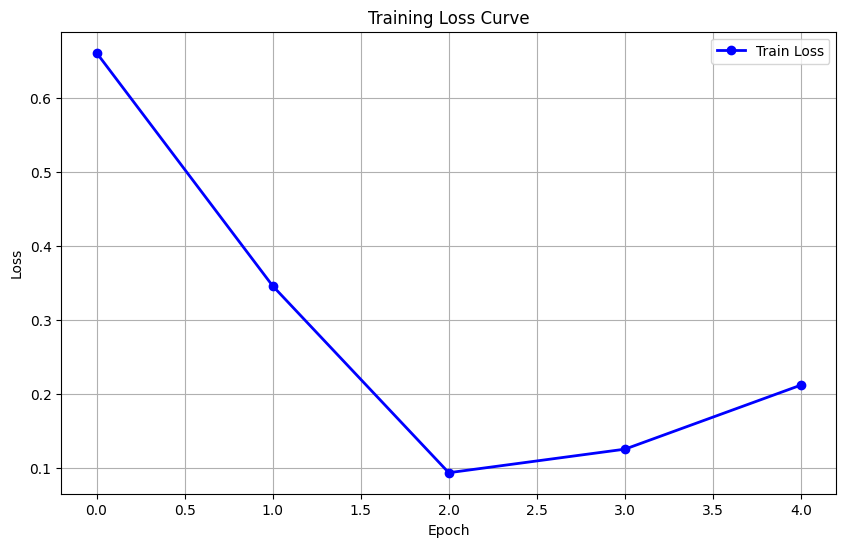

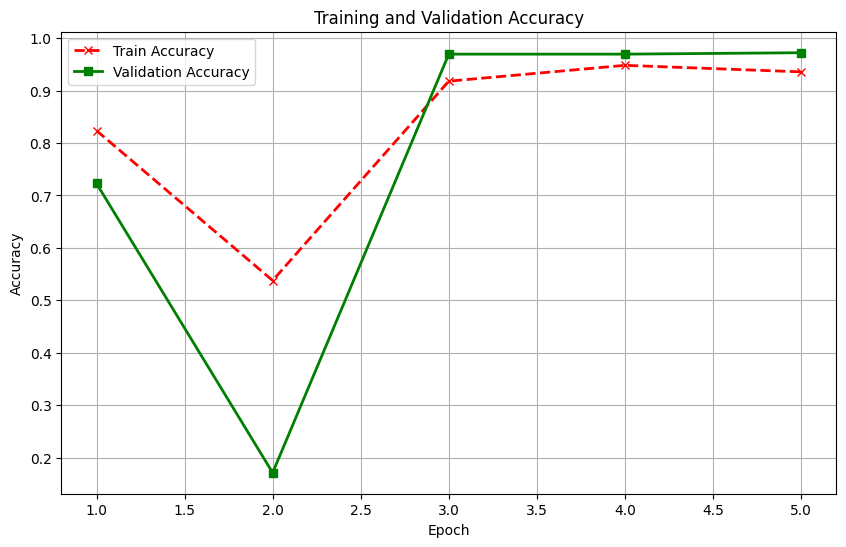

In [ ]:
default = RNN(len(TEXT.vocab.itos), len(TEXT.vocab.itos), n_layers=1)
train(default, train_iter, valid_iter)

In [ ]:
# For next part trail and error
def train_test(model, train, valid, num_epochs=5, learning_rate=1e-4):
    torch.manual_seed(99)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Initializing paramters
    losses, train_acc, valid_acc, epochs = [], [], [], []

    # Let's get started
    print ("Training Started...")
    start_time = time.time()

    # Looping
    for epoch in range(num_epochs):
        # Training
        for sms, labels in train:
            optimizer.zero_grad()
            pred = model(sms[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

        # Updating paramters
        losses.append(float(loss))
        train_acc.append(get_accuracy(model, train))
        valid_acc.append(get_accuracy(model, valid))
        epochs.append(epoch+1)

        # Printing
        print(f"epoch {epochs[-1]}  |  loss {loss}  |  training acc {train_acc[-1]}  |  validation acc {valid_acc[-1]}")

    print('\nFinished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total training time used: {:.2f} seconds".format(elapsed_time))

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

**Trail 1**:

`Tuning`:
- I halved the learning rate to 0.5e-4 since the default model accuracy seems reaching a bottleneck in 3 epochs
- I increased the number of epochs to observe the result for more iterations

`Result`:
- epoch 10  |  loss 0.2809720039367676  |  training acc 0.9330453563714903  |  validation acc 0.9730941704035875

`Thoughts`:
- The model performs very well. Both the training and validation accuracy are above 90% in most epochs
- And majority of the time, the validation accuracy is higher than the training accuracy

In [ ]:
RNN_one = RNN(len(TEXT.vocab.itos), len(TEXT.vocab.itos), n_layers=1)
train_test(model=RNN_one, train=train_iter, valid=valid_iter, num_epochs=10, learning_rate=0.5e-4)

Training Started...
epoch 1  |  loss 0.6781896948814392  |  training acc 0.9049676025917927  |  validation acc 0.9336322869955157
epoch 2  |  loss 0.658193051815033  |  training acc 0.8740654593786343  |  validation acc 0.8215246636771301
epoch 3  |  loss 0.6837350726127625  |  training acc 0.7567702276125602  |  validation acc 0.590134529147982
epoch 4  |  loss 0.3225615918636322  |  training acc 0.9453397574347898  |  validation acc 0.9506726457399103
epoch 5  |  loss 0.30516794323921204  |  training acc 0.9318823724871241  |  validation acc 0.9605381165919282
epoch 6  |  loss 0.23977957665920258  |  training acc 0.9357036052500415  |  validation acc 0.9641255605381166
epoch 7  |  loss 0.44423913955688477  |  training acc 0.9149360358863599  |  validation acc 0.9641255605381166
epoch 8  |  loss 0.40266740322113037  |  training acc 0.9335437780362187  |  validation acc 0.9721973094170404
epoch 9  |  loss 0.3758009672164917  |  training acc 0.9096195381292573  |  validation acc 0.96412

**Trail 2**:

`Tuning`:

- I increased the number of layers in the GRU RNN layer to 2
- I doubled the size of the hidden layers in the RNN

`Result`:

- epoch 10  |  loss 0.06611894816160202  |  training acc 0.9700947001162984  |  validation acc 0.9659192825112107

`Thoughts`:

- The losses show a clear sign of converging rather than fluctuating around
- And the model was again performing very well as shown by its validation accuracy
- However, it took 4 times more time to train the model, so rather than playing with the hyper-parameters, we'll try to modify the architecture of our RNN model


In [ ]:
vocab_len = len(TEXT.vocab.itos)
print(vocab_len)

112


In [ ]:
RNN_two = RNN(vocab_len, vocab_len*2, n_layers=2)
train_test(model=RNN_two, train=train_iter, valid=valid_iter, num_epochs=10, learning_rate=0.5e-4)

Training Started...
epoch 1  |  loss 0.6684027314186096  |  training acc 0.5264994185080578  |  validation acc 0.17040358744394618
epoch 2  |  loss 0.24090030789375305  |  training acc 0.941352384116963  |  validation acc 0.9426008968609866
epoch 3  |  loss 0.29177364706993103  |  training acc 0.9390264163482306  |  validation acc 0.9695067264573991
epoch 4  |  loss 0.1562773883342743  |  training acc 0.9559727529489949  |  validation acc 0.9704035874439462
epoch 5  |  loss 0.1181669607758522  |  training acc 0.9554743312842665  |  validation acc 0.9730941704035875
epoch 6  |  loss 0.10870343446731567  |  training acc 0.9594617046020933  |  validation acc 0.957847533632287
epoch 7  |  loss 0.04451797157526016  |  training acc 0.9337099185911281  |  validation acc 0.9130044843049328
epoch 8  |  loss 0.03736570104956627  |  training acc 0.9659411862435621  |  validation acc 0.9659192825112107
epoch 9  |  loss 0.021364638581871986  |  training acc 0.9396909785678684  |  validation acc 0.9

In [ ]:
# Our 2nd RNN neural network
class goRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers=1, dropout_rate=0.5, intermediate_size=33):
        super(goRNN, self).__init__()

        # Store vocab_size for one-hot encoding within the model
        self.vocab_size = vocab_size

        # Recurrent neural network
        self.rnn = nn.GRU(vocab_size, hidden_size, n_layers, batch_first=True)

        # Intermediate size for additional complexity in the classifier
        # Adding a dropout layer for regularization
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, intermediate_size),  # Adjust for bidirectional output
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(intermediate_size, 2)
        )

    def forward(self, x):
        # One-hot encoding
        one_hot = torch.nn.functional.one_hot(x, num_classes=self.vocab_size).float()

        # Pass the one-hot encoded input to the RNN
        output, _ = self.rnn(one_hot)

        # Pooling: Combining max and average pooling
        max_pooled = torch.max(output, dim=1)[0]
        avg_pooled = torch.mean(output, dim=1)
        pooled = torch.cat((max_pooled, avg_pooled), dim=1)

        # Classifier
        output = self.classifier(pooled)

        return output

**Trail 3**:

`Tuning`:

- I added an extra fully connected layer for the classifier
- For the fully connected layer, I included a dropout as a regularization
- I combined the max pooling with the average pooling

`Result`:

- epoch 10  |  loss 0.36116886138916016  |  training acc 0.9579664396079083  |  validation acc 0.9766816143497757

`Thoughts`:

- The losses are going up and down around, despite the validation accuracy performs better than the training accuracy after epoch 3
- Perhaps we can lower the dropout rate as we don't have a large dataset and increase the intermediate fc layer size

In [ ]:
RNN_three = goRNN(vocab_len, vocab_len, n_layers=2)
train_test(model=RNN_three, train=train_iter, valid=valid_iter, num_epochs=10, learning_rate=0.5e-4)

Training Started...
epoch 1  |  loss 0.7371086478233337  |  training acc 0.5195215152018607  |  validation acc 0.13901345291479822
epoch 2  |  loss 0.7233208417892456  |  training acc 0.522179764080412  |  validation acc 0.1515695067264574
epoch 3  |  loss 0.4225027561187744  |  training acc 0.8365176939690978  |  validation acc 0.7443946188340808
epoch 4  |  loss 0.12160764634609222  |  training acc 0.9418508057816913  |  validation acc 0.9713004484304932
epoch 5  |  loss 0.03566241264343262  |  training acc 0.9566373151686327  |  validation acc 0.9757847533632287
epoch 6  |  loss 0.6166055202484131  |  training acc 0.9558066123940854  |  validation acc 0.9757847533632287
epoch 7  |  loss 0.16875630617141724  |  training acc 0.96045854793155  |  validation acc 0.9739910313901345
epoch 8  |  loss 0.06343153119087219  |  training acc 0.9597939857119123  |  validation acc 0.9713004484304932
epoch 9  |  loss 0.0889163464307785  |  training acc 0.9582987207177271  |  validation acc 0.96143

**Trail 4**:

`Tuning`:

- I lowered the dropout rate to 0.2
- I increased the intermediate fc layer size to 66

`Result`:

- epoch 10  |  loss 0.16090509295463562  |  training acc 0.9672703106828376  |  validation acc 0.9695067264573991

`Thoughts`:

- The losses of this model show a sign of converging
- And the validation accuracty of the model again performs very well
- However, comparing all the models that we have trained, the second RNN model seems performing the best
- Although it requires a much longer training time, its losses shows a clear sign of converging and its validation accuracy perfroms very good as well

In [ ]:
RNN_four = goRNN(vocab_len, vocab_len, n_layers=2, dropout_rate=0.2, intermediate_size=66)
train_test(model=RNN_four, train=train_iter, valid=valid_iter, num_epochs=10, learning_rate=0.5e-4)

Training Started...
epoch 1  |  loss 0.6747146248817444  |  training acc 0.5946170460209337  |  validation acc 0.2968609865470852
epoch 2  |  loss 0.6410732269287109  |  training acc 0.7848479813922579  |  validation acc 0.6304932735426009
epoch 3  |  loss 0.3248693645000458  |  training acc 0.9313839508223958  |  validation acc 0.9515695067264573
epoch 4  |  loss 0.4587426483631134  |  training acc 0.9451736168798803  |  validation acc 0.9452914798206278
epoch 5  |  loss 0.3254384398460388  |  training acc 0.9524838012958964  |  validation acc 0.9479820627802691
epoch 6  |  loss 0.13516803085803986  |  training acc 0.9559727529489949  |  validation acc 0.95695067264574
epoch 7  |  loss 0.04790904000401497  |  training acc 0.9606246884864595  |  validation acc 0.9605381165919282
epoch 8  |  loss 0.24707536399364471  |  training acc 0.9587971423824555  |  validation acc 0.9515695067264573
epoch 9  |  loss 0.1432945281267166  |  training acc 0.9629506562551919  |  validation acc 0.970403

Model for the following section(s):

In [ ]:
torch.save(RNN_two.state_dict(), "/content/2nd_model")

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid_set.examples if e.label == 1], # 1 -> spam
    valid_set.fields)

valid_spam_iter = torchtext.data.BucketIterator(valid_spam,
                                                batch_size=32,
                                                sort_key=lambda x: len(x.sms), # to minimize padding
                                                sort_within_batch=True,        # sort within each batch
                                                repeat=False)                  # repeat the iterator for many epochs

# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid_set.examples if e.label == 0], # 0 -> non-spam
    valid_set.fields)

valid_nospam_iter = torchtext.data.BucketIterator(valid_nospam,
                                                  batch_size=32,
                                                  sort_key=lambda x: len(x.sms), # to minimize padding
                                                  sort_within_batch=True,        # sort within each batch
                                                  repeat=False)                  # repeat the iterator for many epochs

### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [ ]:
# best trained model
best_model = RNN_two

In [ ]:
# computing for false pos/neg rates
print(f"False positive rate: {(1 - get_accuracy(best_model, valid_nospam_iter))}.")
print(f"False negative rate: {(1 - get_accuracy(best_model, valid_spam_iter))}.")

False positive rate: 0.03011422637590866.
False negative rate: 0.06578947368421051.


## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
print(f"The final test accuracy is {get_accuracy(best_model, test_iter)}.")

The final test accuracy is 0.966786355475763.


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam test examples
test_spam = torchtext.data.Dataset(
    [e for e in test_set.examples if e.label == 1],
    test_set.fields)

test_spam_iter = torchtext.data.BucketIterator(test_spam,
                                               batch_size=32,
                                               sort_key=lambda x: len(x.sms), # to minimize padding
                                               sort_within_batch=True,        # sort within each batch
                                               repeat=False)                  # repeat the iterator for many epochs

# Create a Dataset of only non-spam test examples
test_nospam = torchtext.data.Dataset(
    [e for e in test_set.examples if e.label == 0],
    test_set.fields)

test_nospam_iter = torchtext.data.BucketIterator(test_nospam,
                                                 batch_size=32,
                                                 sort_key=lambda x: len(x.sms), # to minimize padding
                                                 sort_within_batch=True,        # sort within each batch
                                                 repeat=False)                  # repeat the iterator for many epochs

In [ ]:
# computing for false pos/neg rates
print(f"False positive rate: {(1 - get_accuracy(best_model, test_nospam_iter))}.")
print(f"False negative rate: {(1 - get_accuracy(best_model, test_spam_iter))}.")

False positive rate: 0.030051813471502542.
False negative rate: 0.046979865771812124.


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"
input_tokens = []

for char in msg:
    input_tokens.append(torch.tensor(TEXT.vocab.stoi[char]))

play = torch.stack(input_tokens)
play.unsqueeze_(0) # fitting for the model

print(f"Probability of being spam is: {F.softmax(best_model(play), dim=1)[0][1].item()}.")

Probability of being spam is: 0.3415350317955017.


Comment: lol. there is a ~34% chance that "machine learning is sooo cool!" is spam 😆 XD

### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

Response:

- Spam detection is `a constantly evolving challenge`, as spammers continually develop new tactics to bypass filters. While applications like Gmail have developed advanced methods for filtering spam, these systems must be regularly updated to keep up with the latest spamming techniques. This makes spam detection easier in some respects, especially compared to more complex machine learning tasks like generating "new" content. However, it remains a task with its unique challenges due to the ever-changing nature of spam.

- A good starting point for detecting spam is using `a simple, rule-based algorithm`. This approach involves setting up rules to identify common characteristics of spam, such as excessive use of capital letters or certain words that are frequently found in spam but not in regular messages, like "FREE" or "MONEY". While this method is straightforward to implement, it lacks the nuanced understanding of language that more advanced machine learning models provide. For example, heuristic filters can be used to enhance this, which scans emails for suspicious words and assigns points based on these occurrences.
